## Advanced Lane Lines detection

### Import Packages

In [3]:
import os
import numpy as np
import glob
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import pickle
import cv2
%matplotlib inline

out_dir = './output_images/'
test_dir = './test_images/'
camera_cal_dir = './camera_cal/'
camera_cal_done_dir = './camera_cal_done/'
intermediate_dir = './intermediate_images/'

### Camera Calibration

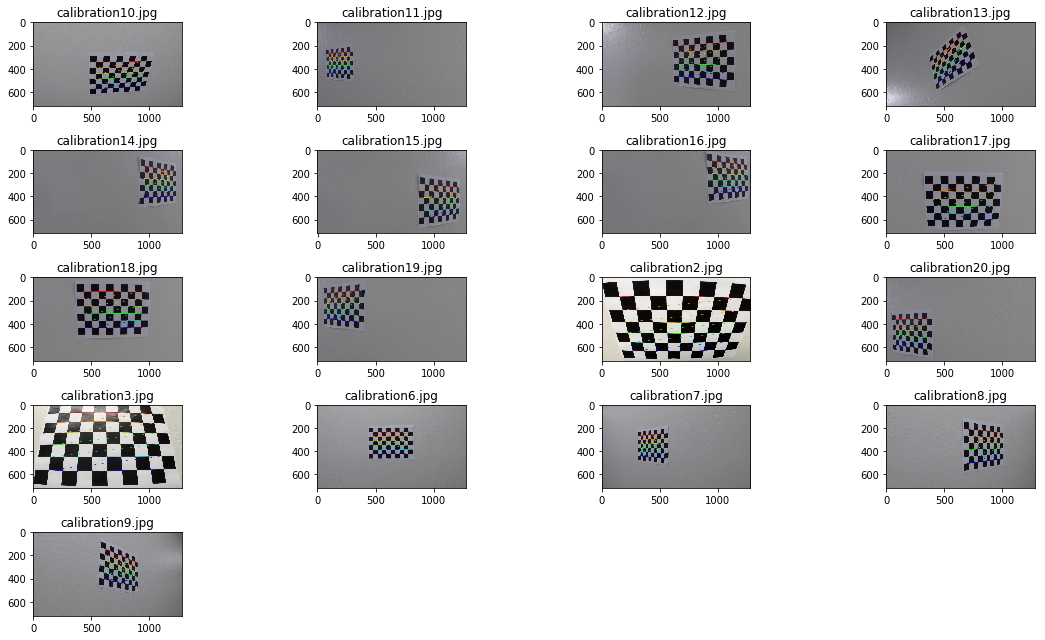

In [2]:
images = sorted(glob.glob(camera_cal_dir + 'cal*.jpg'))

objpoints = [] # 3d points
imgpoints = [] # 2d points in image

nx = 9
ny = 6
# prepare obj points
objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

n_image = len(images)
# subplot the images, 4 images per row
n_image_per_row = 4
row = (n_image - 1) / n_image_per_row + 1 
idx = 1
plt.figure(figsize=(16,9))
for fimg in images:
    img = cv2.imread(fimg)
    name = fimg.split('\\')[-1]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, draw corners
    if ret == True:
        objpoints.append(np.copy(objp))
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.subplot(row, n_image_per_row, idx)
        idx += 1
        cv2.imwrite(intermediate_dir + "find_corner_" + name, img)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(name)
plt.tight_layout()
plt.show()

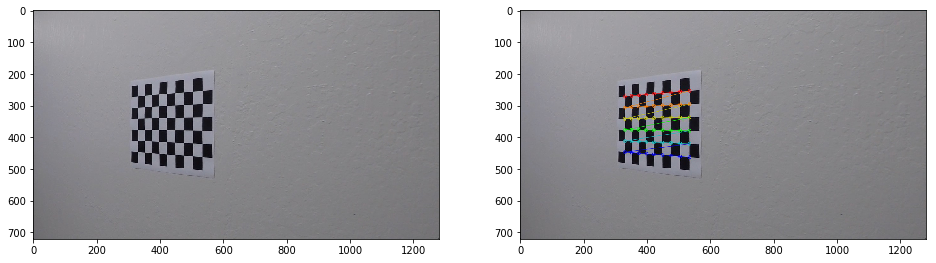

In [4]:
# example of camera calibration
import random
n_pick = random.randint(0, len(images))
img_dist = mpimg.imread(images[n_pick])
# show result of find corners
name = images[n_pick].split('\\')[-1]
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow(img_dist)
plt.subplot(1,2,2)
plt.imshow(mpimg.imread(intermediate_dir + 'find_corner_' + name))
plt.show()

#### undistort image

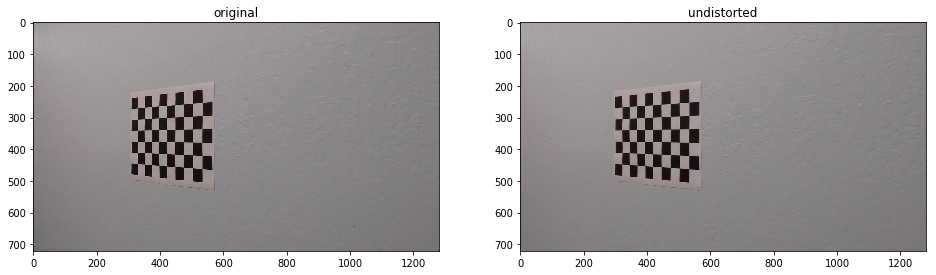

In [5]:
# undistort image
img = cv2.imread(images[n_pick])
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
# plot
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(dst)
plt.title('undistorted')
plt.show()

In [6]:
# use pickle to save mtx and dist
p = {
    'mtx': mtx,
    'dist': dist
}
with open('./camera_mtx_dist.p', 'wb') as f:
    pickle.dump(p, f)

In [7]:
# use pickle to load mtx, and dist
# load it in case crash
with open('./camera_mtx_dist.p', 'rb') as f:
    p = pickle.load(f)
mtx = p['mtx']
dist = p['dist']

#### useful functions

In [8]:
# select one image and define 4 points on
# both source and destination images
def warp_image(img, nxy=(9,6), offset=100):
    nx = nxy[0]
    ny = nxy[1]
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corner = cv2.findChessboardCorners(undist_gray, (nx, ny), None)
    warped = None
    M = None
    if ret: # found
        h, w = img.shape[:2]
        src = np.float32([corner[0], corner[nx-1],
                            corner[-1], corner[-nx]])
        dst = np.float32([[offset, offset],
                            [w-offset, offset],
                            [w-offset, h-offset],
                            [offset, h-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, (w, h),  flags=cv2.INTER_LINEAR)
    return warped, M

# sobel
def abs_sobel_thresh(sx, sy, orient='x', sobel_thresh=(0, 255)):
    if orient == 'x':
        sobel = sx
    else:
        sobel = sy
    sobel_abs = np.absolute(sobel)
    sobel8bit = np.uint8(255. * sobel_abs/np.max(sobel_abs))
    binary_output = np.zeros_like(sobel8bit)
    binary_output[(sobel8bit > sobel_thresh[0]) & (sobel8bit < sobel_thresh[1])] = 1
    return binary_output

def mag_threshold(sx, sy, mag_thresh=(0, 255)):
    # threshold range: [50, 100]
    grd = np.absolute(np.sqrt(np.square(sx) + np.square(sy)))
    # normalize
    grd = np.uint8(255 * grd / np.max(grd))
    binary_out = np.zeros_like(gray)
    binary_out[(grd > mag_thresh[0]) & (grd < mag_thresh[1])] = 1
    return binary_out

def dir_threshold(sx, sy, thresh=(0, np.pi/2)):
    gdir = np.arctan2(sy, sx)
    binary_output = np.zeros_like(gray)
    binary_output[(gdir >= thresh[0]) & (gdir <= thresh[1])] = 1
    return binary_output

def grad(img, sobel_kernel, sobel_thresh=(0, 255), mag_thresh=(0, 255), dir_thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sy = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    mag_bin = mag_threshold(sx, sy, mag_thresh)
    dir_bin = dir_threshold(sx, sy, dir_thresh)
    sx_bin = abs_sobel_thresh(sx, sy, 'x', sobel_thresh)
    sy_bin = abs_sobel_thresh(sx, sy, 'y', sobel_thresh)
    combined = np.zeros_like(dir_bin)
    combined[((sx_bin == 1) & (sy_bin == 1)) | ((mag_bin == 1) & (dir_bin == 1))] = 1
    return combined

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s > thresh[0]) & (s <= thresh[1])] = 1
    return binary_output


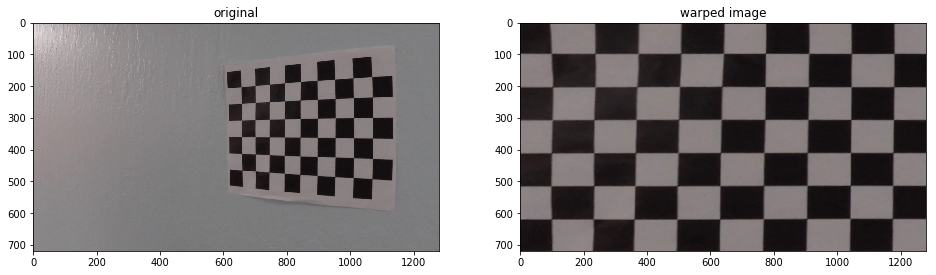

In [9]:
# warp chessboard. already have mtx, dist
img = cv2.imread(images[3])
warped_chessboard, M = warp_image(img)
# plot
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(warped_chessboard)
plt.title('warped image')
plt.show()

### Build pipeline

#### undistort road test image

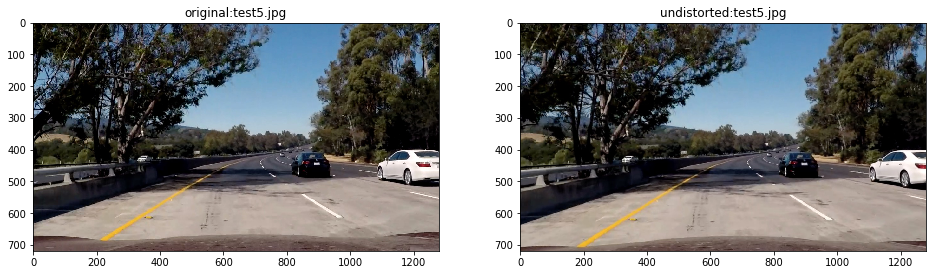

In [10]:
# apply undistort to test image
test_images = glob.glob(test_dir + 'test*.jpg')
n_pick = random.randint(0, len(test_images))
name = test_images[n_pick].split('\\')[-1]
img = cv2.imread(test_images[n_pick])
dst = cv2.undistort(img, mtx, dist, None, mtx)
# plot
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('original:'+ name)
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.title('undistorted:'+ name)
plt.show()


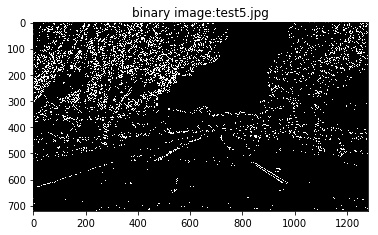

In [11]:
# generate binary image
binary_image = grad(img, sobel_kernel=3,
                    sobel_thresh=(20, 100),
                    mag_thresh=(20, 100),
                    dir_thresh=(0.7, 1.3))
plt.imshow(binary_image, cmap='gray')
plt.title('binary image:' + name)
plt.show()

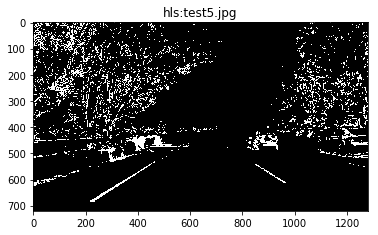

In [12]:
# hls transform
bin_hls = hls_select(img, thresh=(180, 255))
plt.imshow(bin_hls, cmap='gray')
plt.title('hls:' + name)
plt.show()

#### color / gradient combination

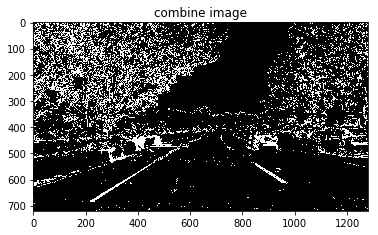

In [13]:
color_binary = np.dstack((np.zeros_like(bin_hls), bin_hls, binary_image)) * 255
combined = np.zeros_like(bin_hls)
combined[(bin_hls == 1) | (binary_image==1)] = 1
plt.imshow(combined, cmap='gray')
plt.title('combine image')
plt.show()

#### warp road image

In [14]:
def warp_line(img, calcM=False, M=None, bin_img=False):
    if not bin_img:
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        undist_gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)  
        pers_img = undist
    else:
        pers_img = img
    warped = None
    h, w = img.shape[:2]
    if calcM:
        M = None
        Minv = None
    # select 4-corners of trapezoid, bot-left, top-left, top-right, bot-right
    #src = np.float32([[667, 275], [449, 599], [449, 683], [667, 1026]])
        src = np.float32([[260, 681], [592, 452], [686, 452], [1042, 681]])
        dst = np.float32([[w/4, h],[w//4, 0],[w//4*3, 0],[w//4*3, h]])
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(pers_img, M, (w, h),  flags=cv2.INTER_LINEAR)
        return warped, M, Minv   
    else:
        warped = cv2.warpPerspective(pers_img, M, (w, h), flags=cv2.INTER_LINEAR)
        return warped

In [15]:
test_img_straight = cv2.imread(r'C:\Downloads\Tensor\CarND-Advanced-Lane-Lines\test_images\straight_lines1.jpg')
undist = cv2.undistort(test_img_straight, mtx, dist, None, mtx)
cv2.imwrite(r'C:\Downloads\Tensor\CarND-Advanced-Lane-Lines\output_images\undist_straight_line1.jpg', undist)


True

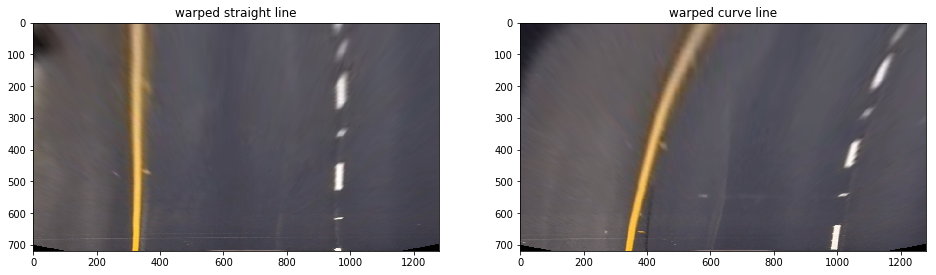

In [34]:
# warp test image
test_img_straight = cv2.imread(r'C:\Downloads\Tensor\CarND-Advanced-Lane-Lines\test_images\straight_lines1.jpg')
warped, M, Minv = warp_line(test_img_straight, calcM=True)
straight_warped = warp_line(test_img_straight, calcM=False, M=M)
# apply M to other test image
test_img_curve = cv2.imread(r'C:\Downloads\Tensor\CarND-Advanced-Lane-Lines\test_images\test3.jpg')
test_warped = warp_line(test_img_curve, calcM=False, M=M)
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(straight_warped, cv2.COLOR_BGR2RGB))
plt.title('warped straight line')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(test_warped, cv2.COLOR_BGR2RGB))
plt.title('warped curve line')
plt.show()

### Pipeline

#### calculate curvature

In [17]:
# calculate curvature
def get_curvature(left_fit, right_fit, y):
    left_curverad = ((1 + (2*left_fit[0]*y + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad
def get_curvature_in_meter(lefty, righty, leftx, rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 40/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = 720
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return(left_curverad,right_curverad)


#### inverse perspectiveTransform

In [41]:
# draw on the lane
def draw_on_lane(warped, left_fitx, right_fitx, ploty, Minv, undist,text=""):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    (h, w) = warp_zero.shape
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    if text != "":
        result = cv2.putText(result, text, (30,70), 0, 1, (0,0,0), 2, cv2.LINE_AA)
    return result

def get_car_position(warped, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    (h, w) = warp_zero.shape
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image

In [19]:
# define Line class
Y_BOTTOM = 720
class Line():
    def __init__(self,left_fit=[np.array([0,0,0], dtype='float')]  , right_fit=np.array([0,0,0], dtype='float')):
        # recent n of x values
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients for the most recent fit
        self.left_fit_co = left_fit 
        self.right_fit_co = right_fit
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # lane spacing
        self.lane_space = 0
        # lane histo
        self.hist = None
    def valid_line(self, prev_line):
        if not prev_line or not prev_line.lane_space or not prev_line.radius_of_curvature:
            return False
        error_radius = abs(self.radius_of_curvature - prev_line.radius_of_curvature) * 1.0 / prev_line.radius_of_curvature
        error_lane_space = abs(self.lane_space - prev_line.lane_space) * 1.0 / prev_line.lane_space
        return (error_radius > 0.15 or error_lane_space > 0.15)
        

#### processing image with sliding window

In [47]:
# sliding window and polyfit
def proc_image(img, n=1, show=False):
    offset = 0
    global last_lane, cnt, cnt_total
    cnt_total += 1
    # incoming image is RGB
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    bin_img = grad(img, sobel_kernel=3, 
                   sobel_thresh=(20, 100),
                   mag_thresh=(20, 100),
                   dir_thresh=(0.7, 1.3))
    bin_hls = hls_select(img, thresh=(180, 255))
    color_binary = np.dstack((np.zeros_like(bin_hls), bin_hls, bin_img)) * 255
    combined = np.zeros_like(bin_hls)
    combined[(bin_hls == 1) | (bin_img==1)] = 1
    warp_img = warp_line(combined, calcM=False, M=M, bin_img=True)
    nonzero = warp_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # windows size = 2 * margin
    margin = 100
    hist = np.sum(warp_img[warp_img.shape[0]//2:,:], axis=0)
    # smart search first
    if last_lane:
        left_fit = last_lane.left_fit_co
        right_fit = last_lane.right_fit_co
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  
 
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # new lane obj
        cur_lane = Line(left_fit, right_fit)
        cur_lane.hist = hist
        cur_lane.radius_of_curvature = np.average(get_curvature(left_fit, right_fit, Y_BOTTOM))
        # Generate x and y values for plotting
        ploty = np.linspace(0, warp_img.shape[0]-1, warp_img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        cur_lane.lane_space = abs(right_fitx[-1] - left_fitx[-1])
        if cur_lane.valid_line(last_lane):
            cnt += 1
            last_n_x = len(last_lane.recent_xfitted)
            x_drop = (0, 0)
            cur_lane.recent_xfitted = last_lane.recent_xfitted[:]
            if last_n_x == n:
                # full, pop the first
                last_n_x -= 1
                x_drop = cur_lane.recent_xfitted.pop(0)
            cur_lane.recent_xfitted.append((left_fitx[-1], right_fitx[-1]))
            last_n_x += 1
            ave_left = last_lane.bestx[0] + (- x_drop[0] + left_fitx[-1])/last_n_x
            ave_right = last_lane.bestx[1] + (- x_drop[1] + right_fitx[-1])/last_n_x
            cur_lane.bestx = (ave_left, ave_right)
            last_lane = cur_lane
            offset = (warp_img.shape[1]/2 - (left_fitx[-1] + right_fitx[-1])/2) * 3.7/700
            label_str = 'offset from center: {:.3f} m'.format(offset)
            return draw_on_lane(warp_img, left_fitx, right_fitx, ploty, Minv, img, text=label_str)

    # not valid, need to restart a sliding window search
    # sliding window and fit polynomial
    out_img = np.dstack((warp_img, warp_img, warp_img)) * 255
    midpoint = np.int(hist.shape[0]//2)
    # test
    if last_lane:
        hist_merge = last_lane.hist + hist
    else:
        hist_merge = hist
    leftx_base = np.argmax(hist_merge[:midpoint])
    rightx_base = np.argmax(hist_merge[midpoint:]) + midpoint
    nwindows = 8
    window_height = warp_img.shape[0] // nwindows
    # min num of pixels to recenter window
    minpixel = 50
    cur_left = leftx_base
    cur_right = rightx_base
    left_lane_inds, right_lane_inds = [],[]
    for window in range(nwindows):
        win_y_low = warp_img.shape[0] - (window+1)*window_height
        win_y_high = warp_img.shape[0] - window*window_height
        win_xleft_low = cur_left - margin
        win_xleft_high = cur_left + margin
        win_xright_low = cur_right - margin
        win_xright_high = cur_right + margin
        # Draw the windows on the visualization image
        if show:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpixel:
            cur_left = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpixel:        
            cur_right = np.int(np.mean(nonzerox[good_right_inds]))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, warp_img.shape[0]-1, warp_img.shape[0] )
    left_curv, right_curv = get_curvature_in_meter(lefty, righty, leftx, rightx)
    # visualization
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if show:
        print('Curvature\n-left:\t{}m\n-right:\t{}m'.format(left_curv, right_curv))
        plt.figure(figsize=(16, 8))
        plt.subplot(1,2,1)
        plt.plot(hist)
        plt.title('histogram of the lane')
        plt.subplot(1,2,2)
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.title('sliding windows')
        plt.show()
    #
    last_lane = Line(left_fit, right_fit)
    last_lane.radius_of_curvature = np.average(get_curvature(left_fit, right_fit, Y_BOTTOM))
    last_lane.recent_xfitted.append((left_fitx[-1], right_fitx[-1]))
    last_lane.bestx = (left_fitx[-1], right_fitx[-1])
    last_lane.lane_space = abs(right_fitx[-1] - left_fitx[-1])
    last_lane.hist = hist
    offset = (warp_img.shape[1]/2 - (left_fitx[-1] + right_fitx[-1])/2) * 3.7/700
    label_str = 'offset from center: {:.3f} m'.format(offset)
    res_image = draw_on_lane(warp_img, left_fitx, right_fitx, ploty, Minv, img, text=label_str)
    return res_image

Curvature
-left:	1108.5585557464196m
-right:	1080.0192961797668m


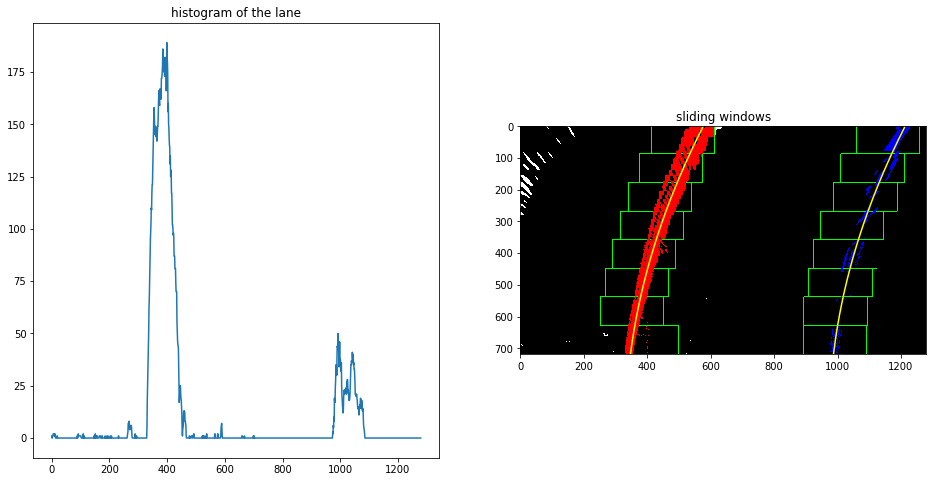

In [48]:
last_lane = None
cnt, cnt_total = 0, 0
inv_warp_image = proc_image(test_img_curve, show=True)

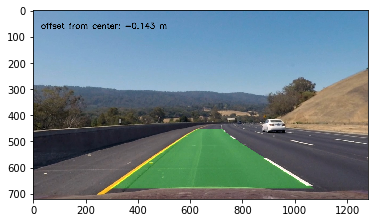

In [49]:
# plot found lane
plt.imshow(cv2.cvtColor(inv_warp_image, cv2.COLOR_BGR2RGB))
#plt.imshow(inv_warp_image)
plt.show()

In [29]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
# process video
last_lane = None
cnt, cnt_total = 0, 0
def proc_image_wrapper(image):
    n = 5
    return proc_image(image, n, False)
    
video = './project_video.mp4'
video_output = 'out_project_video.mp4'
clip1 = VideoFileClip(video)
out_clip = clip1.fl_image(proc_image_wrapper) #NOTE: this function expects color images!!
%time out_clip.write_videofile(video_output, audio=False)
HTML("""<video width="480" height="360" controls><source src="{0}"></video>""".format(video_output))

[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|███████████████████████████████████████████████████████████████████▉| 1260/1261 [03:47<00:00,  5.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

Wall time: 3min 48s
